In [1]:
using Interpolations
using ProfileView
using ForwardDiff
using PyPlot
using FixedSizeArrays

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
include("Acrobots/src/Acrobots.jl")

Acrobots

In [38]:
xdes = Acrobots.DoubleIntegratorState{Float64}(1, 0)
x0 = Acrobots.DoubleIntegratorState{Float64}([rand(); 0])
state = x0
robot = Acrobots.double_integrator()
input = Acrobots.DoubleIntegratorInput{Float64}(0)
dt = 0.001
vis = Acrobots.DrakeVisualizer(robot)
ts = 0:dt:0.1
Qf = diagm([100,1])
Rf = eye(1)

function cost(state::Acrobots.DoubleIntegratorState)
#     if state.theta1 > 0
#         x = convert(Vector, state - xdes)
#     else
#         x = convert(Vector, state - Acrobots.AcrobotState{Float64}(-pi, 0, 0, 0))
#     end
#     return 0.5*(x' * Qf * x)[1]
    x = convert(Vector, state - xdes)
    return 0.5*(x' * Qf * x)[1]
end
Q_generator = ForwardDiff.hessian(x -> cost(Acrobots.DoubleIntegratorState(x)), ForwardDiff.AllResults)

function cost(input::Acrobots.DoubleIntegratorInput)
    return input.u^2
end
R_generator = ForwardDiff.hessian(x -> cost(Acrobots.DoubleIntegratorInput(x)), ForwardDiff.AllResults)

sys_tf = Acrobots.linearize(robot, 0, xdes, input)
P_tf = Mat(Acrobots.care(convert(Matrix, sys_tf.A), convert(Matrix, sys_tf.B), Qf, Rf))
p_tf = -P_tf * xdes

Qs = Mat{2, 2, Float64}[]
Rs = Mat{1, 1, Float64}[]
qs = Vec{2, Float64}[]
rs = Vec{1, Float64}[]
Ps = Mat{2, 2, Float64}[]
ps = Vec{2, Float64}[]

controller_state = Acrobots.LQRState{Float64}(())
linear_sys = Acrobots.linearize(robot, 0, x0, input)
controller = Acrobots.lqr(linear_sys, Qf, Rf, x0)
linearizations = typeof(linear_sys)[]

Profile.clear()
elapsed = @elapsed for (i, t) in enumerate(ts)
    output = Acrobots.output(robot, t, state, input)
    input = Acrobots.output(controller, t, controller_state, output)
    statedot = Acrobots.dynamics(robot, t, state, input)
    state += statedot * dt
    push!(linearizations, Acrobots.linearize(robot, t, state, input))
    
    Q, Q_results = Q_generator(convert(Vector, state))
    push!(Qs, Q)
    push!(qs, ForwardDiff.gradient(Q_results))
    R, R_results = R_generator(convert(Vector, input))
    push!(Rs, R)
    push!(rs, ForwardDiff.gradient(R_results))
    
#     if mod(i, 10) == 0
        Acrobots.draw(vis, state)
#     end
end
@show elapsed / length(ts) * 1e6
# ProfileView.view()

(elapsed / length(ts)) * 1.0e6 = 670.6761584158417

670.6761584158417

In [41]:
Qs[1]

FixedSizeArrays.Mat{2,2,Float64}(
    100.0 0.0
    0.0 1.0
)


In [42]:
qs[1]

FixedSizeArrays.Vec{2,Float64}((-35.37325996143306,1.7669340295517e-8))

In [39]:
alpha = 0.5

for i = 1:10

    Ps = Array{Mat{2, 2, Float64}}(length(ts))
    ps = Array{Vec{2, Float64}}(length(ts))
    Ks = Array{Mat{1, 2, Float64}}(length(ts))
    ls = Array{Vec{1, Float64}}(length(ts))
    As = [dt * sys.A for sys in linearizations]
    Bs = [dt * sys.B for sys in linearizations]

    Ps[end] = P_tf
    ps[end] = p_tf

    for j = (length(ts)-1):-1:1
        g = rs[j] + Bs[j]' * ps[j+1]
        G = Bs[j]' * Ps[j+1] * As[j]
        H = Rs[j] + Bs[j]' * Ps[j+1] * Bs[j]
        Hi = inv(H)
        Ks[j] = -Hi * G
        ls[j] = -Hi * g

        M = inv(Mat{2,2,Float64}(eye(2)) + Bs[j] * inv(Rs[j]) * Bs[j]' * Ps[j+1])
        ps[j] = (As[j]' * (Mat{2,2,Float64}(eye(2)) - Ps[j+1] * M * Bs[j] * inv(Rs[j]) * Bs[j]') * ps[j+1] 
            + As[j]' * Ps[j+1] * M * Bs[j] * linearizations[j].u0 + qs[j])

    #     ps[j] = qs[j] + As[j]' * ps[j+1] + Ks[j]' * H * ls[j] + G' * ls[j] # TODO: can neunertm help?
        Ps[j] = Qs[j] + As[j]' * Ps[j+1] * As[j] + Ks[j]' * H * Ks[j] + Ks[j]' * G + G' * Ks[j]
    end
    Ks[end] = Ks[end-1]
    ls[end] = ls[end-1]

    controllers = [Acrobots.AffineSystem(
        Mat{0,0,Float64}(),
        Mat{0,2,Float64}(),
        Mat{1,0,Float64}(),
        Mat{1,2,Float64}(Ks[j]),
        Acrobots.LQRState{Float64}(),
        Acrobots.DoubleIntegratorOutput{Float64}(linearizations[j].x0),
        Acrobots.LQRState{Float64}(),
        Acrobots.DoubleIntegratorInput{Float64}(linearizations[j].u0) + Acrobots.DoubleIntegratorInput{Float64}(alpha * ls[j])) 
        for j in 1:length(ts)]


    state = x0
    input = Acrobots.AcrobotInput{Float64}(0)
    empty!(linearizations)
    empty!(Qs)
    empty!(Rs)
    empty!(qs)
    empty!(rs)

    elapsed = @elapsed for (i, t) in enumerate(ts)
        output = Acrobots.output(robot, t, state, input)
        input = Acrobots.output(controllers[i], t, controller_state, output)
        statedot = Acrobots.dynamics(robot, t, state, input)
        state += statedot * dt
        push!(linearizations, Acrobots.linearize(robot, t, state, input))

        Q, Q_results = Q_generator(convert(Vector, state))
        push!(Qs, Q)
        push!(qs, ForwardDiff.gradient(Q_results))
        R, R_results = R_generator(convert(Vector, input))
        push!(Rs, R)
        push!(rs, ForwardDiff.gradient(R_results))

        if mod(i, 10) == 0
            Acrobots.draw(vis, state)
        end
    end
    
end

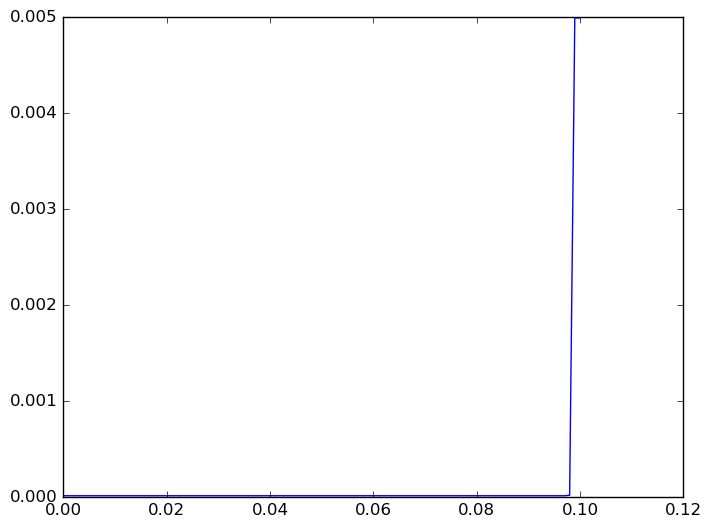

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa6d2228890>

In [40]:
plot(ts, [lin.u0[1] for lin in linearizations])